# Table of contents

xxx


In [1762]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import fine_time_coupling_model
import fine_time_coupling_samples
import smoothing_spline
import util
import hierarchical_sampling_model
import hierarchical_model_generator
import jitter


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1763]:
import allensdk
import h5py
import pynwb
import hdmf
import matplotlib
print('pd', pd.__version__)
print('allensdk', allensdk.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('hdmf', hdmf.__version__)
print('matplotlib', matplotlib.__version__)

pd 1.1.1
allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0
matplotlib 3.3.2


# Homogeneous Hawkes procsses.

For the coupling integration matrix $\Gamma$, row indicates target, column indicate source.
In this way, we have the stability theorem 
$$\Lambda = \mu + \Gamma \Lambda$$
$$\Lambda = (I - \Gamma)^{-1} \mu$$
The last row is a right product, meaning transfering source from the right side to the target on the left side.

#### One neuron.

In [ ]:
filter_par['type'] = 'none'
filter_par['mu'] = [10]

filter_par['type'] = 'exp'
filter_par['mu'] = [6.]
filter_par['alpha'] = [[0.3]]
filter_par['beta'] = [[.5]]

filter_par['type'] = 'triangle'
filter_par['mu'] = [2]
filter_par['alpha'] = [[0.4]]
filter_par['beta'] = [[2]]

filter_par['type'] = 'inv_triangle'
filter_par['mu'] = [10]
filter_par['alpha'] = [[0.5]]
filter_par['beta'] = [[1]]

filter_par['type'] = 'square'
filter_par['mu'] = [20]
filter_par['alpha'] = [[0.8]]
filter_par['beta'] = [[0.4]]

filter_par['type'] = 'delayed_square'
filter_par['mu'] = [10]
filter_par['alpha'] = [[20]]
filter_par['beta'] = [[0.02]]
filter_par['delay'] = 0.1

In [1744]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 30
num_trials = 50

filter_par = {}

filter_par['type'] = 'triangle'
filter_par['mu'] = [2]
filter_par['alpha'] = [[0.4]]
filter_par['beta'] = [[2]]

spike_times = generator.generate_hawkes_spike_times(filter_par, trial_length, num_trials, verbose=False)


lambda stable: [3.33333333]


layers 3, nodes 1, trials 50
mean [101.16]
var  [230.3744]
mean FR: 3.372
ISI mean inv: [3.43646378]


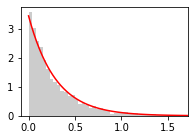

layers 3, nodes 1, trials 50
Mean FR last half: 3.311864406779661


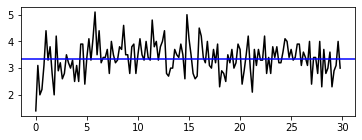

In [1745]:
generator.spike_times_statistics(spike_times, trial_length)
generator.plot_hawkes_psth(spike_times, trial_length, 0.2, filter_par)
# generator.plot_hawkes_intensity(filter_par, spike_times, trial_length, trial_ids=[6], plot_window=[0, 2])

#### Visualize trials with intensity.

In [ ]:
generator.plot_hawkes_intensity(filter_par, spike_times, trial_length, trial_ids=[6], plot_window=[0, 2])

## Two neurons.

In [ ]:
filter_par['type'] = 'none'
filter_par['mu'] = [10, 20]

filter_par['type'] = 'exp'
filter_par['mu'] = [.1, .5]
filter_par['alpha'] = [[0.1, 0.7], [0.5, 0.2]]
filter_par['beta'] = [[1., 1.], [.8, .6]]

filter_par['type'] = 'triangle'
filter_par['mu'] = [2]
filter_par['alpha'] = [[0.4]]
filter_par['beta'] = [[2]]

filter_par['type'] = 'inv_triangle'
filter_par['mu'] = [10]
filter_par['alpha'] = [[0.5]]
filter_par['beta'] = [[1]]

trial_length, num_trials = 20, 20
filter_par['type'] = 'square'
filter_par['mu'] = [10., 20.]
filter_par['alpha'] = [[0.1, 0.3], [0.3, 0.1]]
filter_par['beta'] = [[1.1, 0.6], [0.6, 1.1]]

filter_par['type'] = 'delayed_square'
filter_par['mu'] = [10]
filter_par['alpha'] = [[20]]
filter_par['beta'] = [[0.02]]
filter_par['delay'] = 0.1

In [1766]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length, num_trials = 10, 20

filter_par['type'] = 'square'
filter_par['mu'] = [10., 20.]
filter_par['alpha'] = [[0., 0.0], [0.8, 0.0]]
filter_par['beta'] = [[1.0, 1.0], [1.0, 1.0]]

spike_times = generator.generate_hawkes_spike_times(filter_par, trial_length, num_trials, verbose=False)

lambda stable: [10. 28.]


layers 3, nodes 2, trials 20
mean [102.35 277.6 ]
var  [ 82.3275 438.84  ]
mean FR: 37.995
ISI mean inv: [10.37665387 27.9575431 ]


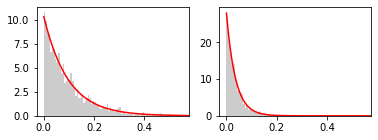

layers 3, nodes 2, trials 20
Mean FR last half: 10.486842105263158
Mean FR last half: 28.75


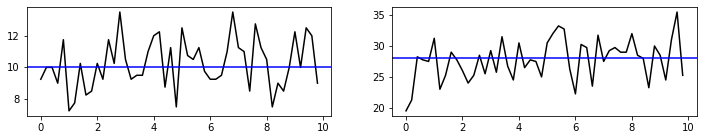

In [1767]:
generator.spike_times_statistics(spike_times, trial_length)
generator.plot_hawkes_psth(spike_times, trial_length, 0.2, filter_par)
# generator.plot_hawkes_intensity(filter_par, spike_times, trial_length, node_ids=[0], trial_ids=[6], plot_window=[0, 2])

#### 3 neurons.

In [ ]:
trial_length, num_trials = 10, 20
filter_par['type'] = 'none'
filter_par['mu'] = [10, 20, 15]

trial_length, num_trials = 20, 50
filter_par['type'] = 'exp'
filter_par['mu'] = [1.0, 2.5, 3.0]
filter_par['alpha'] = [[0.1, 0.2, 0.2], [0.1, 0.2, 0.1], [0.1, 0.2, 0.2]]
filter_par['beta'] = [[2.0, 1.0, 3.0], [0.8, 0.6, 4.0], [2.8, 0.6, 4.0]]
# Slow convergence.
trial_length, num_trials = 120, 10
filter_par['type'] = 'exp'
filter_par['mu'] = [1.0, 2.5, 3.0]
filter_par['alpha'] = [[0.1, 0.7, 0.2], [0.5, 0.2, 0.1], [0.1, 0.5, 0.2]]
filter_par['beta'] = [[2.0, 1.0, 3.0], [0.8, 0.6, 4.0], [2.8, 0.6, 4.0]]

trial_length, num_trials = 20, 300
filter_par['type'] = 'triangle'
filter_par['mu'] = [1, 2, 3]
filter_par['alpha'] = [[0.2, 0.4, 0.8], [0.4, 0.2, 0.9], [0.8, 0.8, 0.4]]
filter_par['beta'] = [[0.3, 0.2, 0.3], [0.5, 0.5, 0.6], [0.5, 0.4, 0.3]]

trial_length, num_trials = 20, 200
filter_par['type'] = 'inv_triangle'
filter_par['mu'] = [1, 2, 3]
filter_par['alpha'] = [[0.2, 0.4, 0.8], [0.4, 0.2, 0.9], [0.8, 0.8, 0.4]]
filter_par['beta'] = [[0.3, 0.2, 0.3], [0.5, 0.5, 0.6], [0.5, 0.4, 0.3]]

trial_length, num_trials = 20, 20
filter_par['type'] = 'square'
filter_par['mu'] = [1, 2, 3]
filter_par['alpha'] = [[0.2, 0.4, 0.2], [0.2, 0.2, 0.2], [0.1, 0.5, 0.2]]
filter_par['beta'] = [[0.5, 0.2, 0.3], [0.5, 0.5, 0.6], [0.5, 0.4, 0.3]]

trial_length, num_trials = 20, 20
filter_par['type'] = 'square'
filter_par['mu'] = [1, 2, 3]
filter_par['alpha'] = [[0.4, 0.8, 0.8], [0.2, 0.2, 0.2], [0.1, 0.5, 0.2]]
filter_par['beta'] = [[0.5, 0.2, 0.3], [0.5, 0.5, 0.6], [0.5, 0.4, 0.3]]
filter_par['delay'] = 0.2

In [1816]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length, num_trials = 20, 20
filter_par['type'] = 'square'
filter_par['mu'] = [1, 2, 3]
filter_par['alpha'] = [[0.4, 0.8, 0.8], [0.2, 0.2, 0.2], [0.1, 0.5, 0.2]]
filter_par['beta'] = [[0.5, 0.2, 0.3], [0.5, 0.5, 0.6], [0.5, 0.4, 0.3]]
filter_par['delay'] = 0.2

spike_times = generator.generate_hawkes_spike_times(filter_par, trial_length, num_trials, verbose=False)

lambda stable: [3.07412141 3.09904153 4.014377  ]


layers 3, nodes 3, trials 5
mean [5305.2 6168.6 6482.6]
var  [46318.96 55361.84 34481.84]
mean FR: 59.85466666666666
ISI mean inv: [17.71315231 20.58062325 21.62804704]


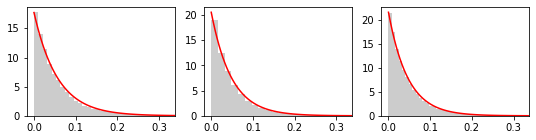

layers 3, nodes 3, trials 5
Mean FR last half: 17.564273789649416
Mean FR last half: 20.465776293823037
Mean FR last half: 21.674457429048413


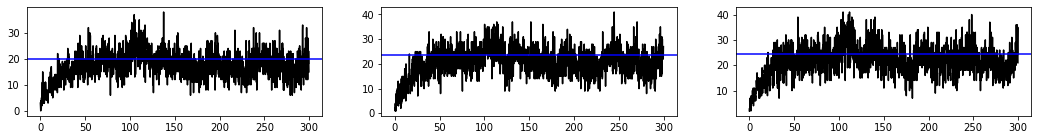

In [1795]:
generator.spike_times_statistics(spike_times, trial_length)
generator.plot_hawkes_psth(spike_times, trial_length, 0.2, filter_par)
# generator.plot_hawkes_intensity(filter_par, spike_times, trial_length, trial_ids=[6], plot_window=[0, 2])

# Synchrony effect

#### 1 neuron.

In [ ]:
filter_par['type'] = 'synchrony'
filter_par['mu'] = [10.]
filter_par['alpha'] = [[0.1]]

filter_par['type'] = 'synchrony'
filter_par['mu'] = [10.]
filter_par['alpha'] = [[0.2]]

In [1739]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
trial_length = 15
num_trials = 300

filter_par['type'] = 'synchrony'
filter_par['mu'] = [10.]
filter_par['alpha'] = [[0.8]]

spike_times = generator.generate_hawkes_spike_times(filter_par, trial_length, num_trials, verbose=False)

lambda stable: [50.]


layers 3, nodes 1, trials 300
mean [753.20666667]
var  [21137.91062222]
mean FR: 50.21377777777778
ISI mean inv: [50.83200163]


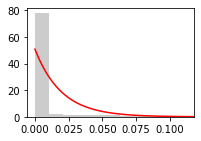

layers 3, nodes 1, trials 300
Mean FR last half: 50.5419540229885


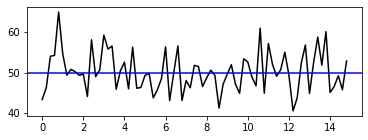

In [1740]:
generator.spike_times_statistics(spike_times, trial_length)
generator.plot_hawkes_psth(spike_times, trial_length, 0.2, filter_par)
# generator.plot_hawkes_intensity(filter_par, spike_times, trial_length, trial_ids=[6], plot_window=[0, 2])

#### more neurons.

In [ ]:
filter_par['type'] = 'synchrony'
filter_par['mu'] = [10.]
filter_par['alpha'] = [[0.1]]

trial_length, num_trials = 10, 200
filter_par['type'] = 'synchrony'
filter_par['mu'] = [2., 5.]
filter_par['alpha'] = [[0.1, 0.2], [0.2, 0.1]]

trial_length, num_trials = 10, 50
filter_par['type'] = 'synchrony'
filter_par['mu'] = [20., 40., 30.]
filter_par['alpha'] = [[0.05, 0.1, 0.05], [0.05, 0.02, 0.1], [0.07, 0.15, 0.02]]

trial_length, num_trials = 15, 400
filter_par['type'] = 'synchrony'
filter_par['mu'] = [2.0, 1.0, 3.0]
Q,_ = np.linalg.qr(np.random.rand(3,3))
filter_par['alpha'] = Q @ np.diag([0.8, 0.2, 0.1]) @ Q.T

np.random.seed(2)
trial_length, num_trials = 15, 80
filter_par['type'] = 'synchrony'
num_nodes = 6
mu_range = [1, 3]
filter_par['mu'] = [1, 2, 3, 0.1, 4, 0.5]
filter_par['alpha'] = np.random.rand(num_nodes, num_nodes) * 0.3 + 0.01

In [1919]:
generator = hierarchical_model_generator.HierarchicalModelGenerator()
np.random.seed(2)
trial_length, num_trials = 15, 80
filter_par['type'] = 'synchrony'
num_nodes = 6
mu_range = [1, 3]
filter_par['mu'] = [1, 2, 3, 0.1, 4, 0.5]
filter_par['alpha'] = np.random.rand(num_nodes, num_nodes) * 0.001 + 0.005

spike_times = generator.generate_hawkes_spike_times(filter_par, trial_length, num_trials, verbose=False)

lambda stable: [1.05894011 2.06005153 3.06041485 0.15919124 4.05794529 0.55999735]


layers 3, nodes 6, trials 80
mean [15.525  30.275  46.3875  2.7875 61.275   8.2625]
var  [19.174375   34.249375   39.06234375  2.24234375 80.274375    9.49359375]
mean FR: 10.9675
ISI mean inv: [1.12320701 2.07448996 3.15245264 0.29912883 4.1731223  0.63722128]


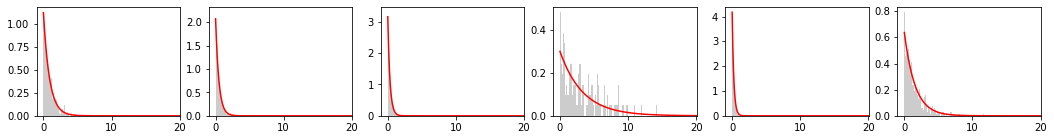

layers 3, nodes 6, trials 80
Mean FR last half: 1.1142241379310343
Mean FR last half: 1.9913793103448276
Mean FR last half: 2.9892241379310347
Mean FR last half: 0.1918103448275862
Mean FR last half: 4.217672413793103
Mean FR last half: 0.5495689655172413


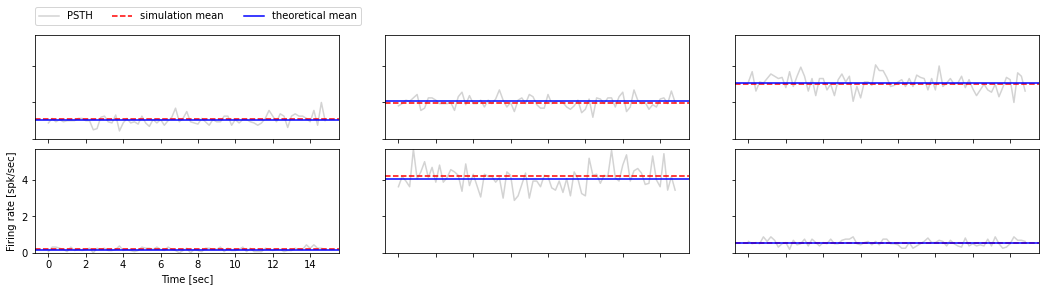

In [1920]:
generator.spike_times_statistics(spike_times, trial_length)
generator.plot_hawkes_psth(spike_times, trial_length, 0.2, filter_par)
# generator.plot_hawkes_intensity(filter_par, spike_times, trial_length, trial_ids=[6], plot_window=[0, 2])

In [1922]:
np.round(filter_par['alpha'], 6)

array([[0.005436, 0.005026, 0.00555 , 0.005435, 0.00542 , 0.00533 ],
       [0.005205, 0.005619, 0.0053  , 0.005267, 0.005621, 0.005529],
       [0.005135, 0.005514, 0.005184, 0.005785, 0.005854, 0.005494],
       [0.005847, 0.00508 , 0.005505, 0.005065, 0.005428, 0.005097],
       [0.005127, 0.005597, 0.005226, 0.005107, 0.00522 , 0.00535 ],
       [0.005468, 0.005202, 0.00564 , 0.005483, 0.005505, 0.005387]])